In [48]:
__description__ = \
"""
Simulate a binding experiment with explicit sampling, binding affinities,
etc.  
"""
__author__ = "Michael J. Harms, harmsm@gmail.com"
__date__ = "2015-04-25"


import numpy as np
import scipy.sparse
import string

AMINO_ACIDS = ("A","C","D","E","F",
               "G","H","I","K","L",
               "M","N","P","Q","R",
               "S","T","V","W","Y")

BASES = ("A","T","G","C")

BINARY = (0,1)

class SeqIntegerMapper:
    """
    To save memory and avoid big-ole dicts, treat sequences as base-"alphabet size" numbers that
    are converted to base 10 integers.  Can handle alphabets up to 36 letters long. As written, we'll
    run out of long ints for 64 bit systems for 15+ amino acid peptides.  
    """
    
    def __init__(self,seq_length,alphabet=AMINO_ACIDS):
        """
        Initialize instance of class.
        """
        
        self._alphabet = ["{:s}".format(s) for s in alphabet]
        self._base = len(alphabet)
        self._seq_length = seq_length
        self.possible_digits = string.digits + string.ascii_lowercase
        
        self.max_int = self._base**(self._seq_length)
        
        self.string_to_base = dict([(letter,self.possible_digits[i]) for i, letter in enumerate(alphabet)])
                
    @property
    def alphabet(self):
        """
        Get alphabet.
        """
        return self._alphabet

    @property
    def base(self):
        """
        Get base.
        """
        return self._base
    
    @property
    def seq_length(self):
        """ Get base. """
        return self._seq_length
        
    def seqToInt(self,sequence_string):
        """
        Return the base 10 integer equivalent of a sequence.
        """
    
        sequence_in_base = "".join([self.string_to_base[s] for s in sequence_string])
        
        return int(sequence_in_base,self._base)
    
    
    def intToSeq(self,sequence_integer):
        """
        Return the sequence encoded by this base 10 integer.
        """
            
        digits = list(self._alphabet[0])*self._seq_length
        i = 0
        while sequence_integer:
            digits[i] = self._alphabet[sequence_integer % self._base]
            sequence_integer //= self._base
            i += 1
          
        digits.reverse()
        
        return "".join(digits)
    
def uniqueCounter(x):
    """
    Count unique elements in an array.  Like bincount but (supposedly) faster and gives
    more useful output.  
    
    Args: (x) one-dimensional numpy array
    Returns: (unique) array of unique entries and (count) how often each element in unique
             was seen. 
    
    Code fragment by Eelco Hoogendoorn
    http://w3facility.org/question/numpy-frequency-counts-for-unique-values-in-an-array/
    """
        
    unique, inverse = np.unique(x, return_inverse=True)
    count = np.zeros(len(unique), np.int)
    np.add.at(count, inverse, 1)
    
    return unique, count #np.vstack(( unique, count)).T



In [55]:
class Pool:
    """
    Class to hold a pool of sequences. 
    
    Important attributes:
    
         _all_seq holds integer representations of every sequence in the initial pool.
         _affinities    holds the relative affinities of each sequence in _all_seq

         _pool_contents is a list of arrays of integers ranging from 0 to len(_all_seq)-1.
                        Each array in the list corresponds to one round in the experiment.
                        Each integer in the arrays maps back to the sequences stored in 
                        _all_seq (and the affinities in _affinities)
         _pool_counts   holds a list of integer arrays storing the counts of each sequence
                        in the pool for a given round. 

    These private attributes can be accessed by a variety public functions. 
    
    The class also contains methods for generating pools and adding new rounds (updating
    the _pool_contents and _pool_counts lists).  
    """ 

    def __init__(self,sequence_length=12,alphabet=BINARY):
        """
        Initialize the class with basic pool properties.
        
        Args: (sequence_length) length of sequences in pool
              (alphabet) possible states at each site in the sequence
        """

        self.sequence_length = sequence_length
        self.alphabet = alphabet[:]
        
        # mapper allows us to convert between internal integer representation and
        # human-readable sequence representations.
        self.mapper = SeqIntegerMapper(self.sequence_length,
                                       tuple(self.alphabet[:]))
        
        # At this point, there are no sequences in the pool...
        self._pool_exists = False
    

    def createUniformPool(self,initial_pool_size,max_K=1e6):
        """
        Generate a pool of "initial_pool_size" sequences, sampling affinities randomly from 1 to max_K.
        Affinities are assigned using randomly chosen log(K) values, but affinity is stored as K values. 
        """
        
        # Create random initial sequences and count them.  mapper.max_int is the 
        # highest possible sequence.  For example, for a 5-mer peptide, this will
        # generate integer equivalents ranging from AAAAA to YYYYY.  
        initial_sample = np.random.randint(0,self.mapper.max_int,initial_pool_size)  
        content, counts = uniqueCounter(initial_sample)
        
        # All sequences seen, as well as their srelative affinities
        self._all_seq = content
        self._affinities = 10**(np.random.uniform(low=0.0,high=np.log10(max_K),size=self._all_seq.size))
        
        # Original pool of sequences
        self._pool_contents = []
        self._pool_contents.append(np.array(range(self._all_seq.size)))
    
        # Original counts in the pool
        self._pool_counts = []
        self._pool_counts.append(counts)                 

        self._pool_checkpoints = [True]
        
        # Now we have a pool to work with.  
        self._pool_exists = True
        
    
    def addNewStep(self,new_contents,new_counts,checkpoint=False):
        """
        Append a new round of selection.  
        """
        
        self._pool_contents.append(new_contents)
        self._pool_counts.append(new_counts)
        self._pool_checkpoints.append(checkpoint)
    
    
    def prettyPrint(self):
        """
        Print out the current round in tabular fashion.  
        """
        
        freq = self.current_counts/sum(self.current_counts)
        for i in self.current_contents:
            print(self.mapper.intToSeq(self._all_seq[self.current_contents[i]]),
                  self.current_counts[i],
                  self.current_affinities[i],
                  freq[i])  
    
    @property
    def pool_exists(self):
        """
        Has the pool actually been populated?
        """
        
        return self._pool_exists
    
    @property
    def current_contents(self):
        """
        The current contents of the pool. 
        """
        
        return self._pool_contents[-1]
    
    @property
    def current_counts(self):
        """
        The current counts of all sequences in the current pool.  
        """
        
        return self._pool_counts[-1]  

    @property
    def current_affinities(self):
        """
        The affinities of all of the sequences in the currrent pool. 
        """
        
        return self._affinities[self._pool_contents[-1]]
    
    @property
    def all_seq(self):
        """
        All sequences ever seen in the pool.  
        """
        
        return self._all_seq
    
    @property
    def all_affinities(self):
        """
        The affinities of every sequence ever seen in the pool. 
        """
        
        return self._affinities 
    
    @property
    def checkpoints(self):
        """
        Checkpoint rounds.  
        """
        return [i for i in range(len(self._pool_checkpoints)) if self._pool_checkpoints[i]]
    
    
    def round_contents(self,round_number):
        """
        Get contents of pool at round round_number.
        """
    
        return self._pool_contents[round_number]
    
    def round_counts(self,round_number):
        """
        Get counts of sequences in pool at round round_number.
        """
    
        return self._pool_counts[round_number]
    
    def round_affinities(self,round_number):
        """
        Get affinities of sequences in pool at round round_number.
        """
    
        return self._affinities[self._pool_contents[round_number]]
    

In [56]:
class SamplerBaseClass(object):
    """
    Class for sampling pools.  
    
    Key attribute is "allow_replace."  If this is False, we are sampling from the whole pool.
    If this is True, we are amplifying the pool.  
    """
    
    def __init__(self):
        """
        Initialize base class.  
        """
        
        self.allow_replace = True
        
    def _sample(self,possibilities,weights=np.array([]),sample_size=0):
        """
        Core sampling function.  
        """
        
        # If weights are specified, use them.
        if weights.size != 0:
            sampled = np.random.choice(possibilities,
                                       size=sample_size,
                                       replace=self.allow_replace,
                                       p=weights)
        else:
            sampled = np.random.choice(possibilities,
                                       size=sample_size,
                                       replace=self.allow_replace)
        
        # Collapse sample into a set of unique sequences with their counts
        return uniqueCounter(sampled)
    
    def poolSanityCheck(self,pool_instance):
        """
        Make sure that it makes sense to sample this pool. 
        """
        
        # Has the pool been populated?
        if not pool_instance.pool_exists:
            err = "pool must be initialized prior to sampling.\n\n"
            raise PhageDisplaySimulatorError(err)
    
    
    def calcWeights(self,pool_instance):
        """
        Weight to place on a given sequence (for sampling with replacement).  For most
        instances, this can just be frequency.  Subclasses may tweak this to include
        other processes.  
        """
        
        return pool_instance.current_counts/(pool_instance.current_counts.sum())
    
    def runExperiment(self,pool_instance,sample_size):
        """
        Run a sampling experiment.  
        
            Args: pool_instance (current pool)
                  sample_size (number of sequences to take forward)
        
            Returns: new_contents (new sequences after sampling)
                     new_counts (number of times each sequence is seen)
        
        """

        # Make sure it even makes sense to run an experiment
        self.poolSanityCheck(pool_instance)
        
        # If the sample_size is bigger than the number of sequences in the pool and
        # we don't allow replacement, just return the whole pool. 
        if sample_size > np.sum(pool_instance.current_counts) and not self.allow_replace:
            return pool_instance.current_contents, pool_instance.current_counts

        else:
            
            # If we allow replacement, do a simple weighted choice
            if self.allow_replace:
                new_contents, new_counts = self._sample(pool_instance.current_contents,
                                                        weights=self.calcWeights(pool_instance),
                                                        sample_size=sample_size)
                
            # If we can't replace, create a possibilities array in which every member of the 
            # pool is repeated as "counts" times.  Then calculate weights accordingly.  
            else:
                possibilities = np.repeat(pool_instance.current_contents,pool_instance.current_counts)
                
                weights = self.calcWeights(pool_instance)
                weights = np.repeat(weights,pool_instance.current_counts)
                weights = weights/np.sum(weights)
                
                new_contents, new_counts = self._sample(possibilities,
                                                        weights=weights,
                                                        sample_size=sample_size)
                
        return new_contents, new_counts
        

class PCRAmplificationSampler(SamplerBaseClass):
    """
    Class for simulating the amplification of phage that occurs via PCR.  
    """

    def __init__(self):
        
        self.allow_replace = True
    

class PhageAmplificationSampler(SamplerBaseClass):
    """
    Class for simulating the amplification of phage that occurs after a binding round.
    """

    def __init__(self):
        
        self.allow_replace = True

class PipetteSampler(SamplerBaseClass):
    """
    Class for simulating the downsampling that occurs when you take a small fraction of the 
    total pool using a pipette.  
    """

    def __init__(self):
        
        self.allow_replace = False

    def calcWeights(self,pool_instance):
        """
        Since we're sampling without replacement, return even weights for every sequence. 
        Degeneracy will be taken care of in the sampling itself.  
        """
    
        return np.ones(pool_instance.current_counts.size,dtype=float)/pool_instance.current_counts.size
        
        
class BindingSampler(SamplerBaseClass):
    """
    Class for simulating downsampling that occurs when the phage are placed on a plate.  
    """
    
    def __init__(self):
        
        self.allow_replace = False
    
    def calcWeights(self,pool_instance):
        """
        Weight by the affinity of the sequence.  Degeneracy will be taken care of since we
        sample without replacement.  
        """
    
        return pool_instance.current_affinities/np.sum(pool_instance.current_affinities)
    

class IlluminaRunSampler(SamplerBaseClass):
    pass
    

In [1]:

from utility import *
from sampling import *
from pool import *


def runMe(sequence_length,num_rounds=3,scalar=10000):

    pipet = PipetteSampler()
    screen = BindingSampler()
    amplify = PhageAmplificationSampler()

    pool = Pool(sequence_length=sequence_length,alphabet=AMINO_ACIDS)
    pool.createUniformPool(100*scalar,1e6)

    print(0,pool.current_counts.size,sum(pool.current_counts))
    for i in range(num_rounds):
        pool.addNewStep(*pipet.runExperiment(pool,1000*scalar))
        pool.addNewStep(*screen.runExperiment(pool,1*scalar))
        pool.addNewStep(*amplify.runExperiment(pool,1000*scalar),checkpoint=True)

        print(i+1,pool.current_counts.size,sum(pool.current_counts))
    
    return pool


In [2]:
pool = runMe(2,num_rounds=3,scalar=1000)


0 400 100000
1 120 1000000
2 74 1000000
3 51 1000000


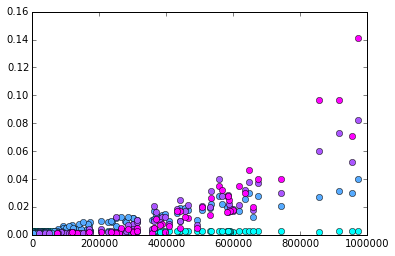

In [3]:

import matplotlib.pyplot as plt
%matplotlib inline

pool.round_affinities(0)

m = max(pool.checkpoints)
for i in pool.checkpoints:
    plt.plot(pool.round_affinities(i),pool.round_counts(i)/np.sum(pool.round_counts(i)),"o",color=[i/m,1-i/m,1])
plt.show()
    

In [1]:
import utility